
# 23S1-AI6124 Stock Trading Project Assignment
Created by A/Prof Kai Keng ANG (kkang@i2r.a-star.edu.sg, kkang@ntu.edu.sg). Last modified 30 Aug 2023

Submitted by: Lu Cheuk Fung Jeff Mat ID: G2304245F

# Instructions
Enter your name according to NTU Learn, and your student ID above. Do not include the square brackets. Please save the file as Project_[Student name].ipynb and submit in NTU Learn.


## Objective

After completing this project, you will know:

Part 1: (Code provided)
* How to download any stock prices to work on
* How to compute buy sell signals on the stock
* How to measure portfolio performance from profit and loss based on buy and sell signals on the stock

Part 2: (To be coded by student)
* How to choose parameters to optimize profits, and explore different trading strategies
* How to apply computational intelligent methods to choose parameters of trading strategies on training data set, then apply to test data set
* How to benchmark the portfolio performance of  computational intelligent methods

Part 3: (To be coded by student)
* How to apply computational intelligent methods to measure the performance of the prediction
* How to interpret and explain the computational intelligent method in predicting the stock prices
* How to apply the stock price prediction to help increase profits, and benchmark the portfolio performance with and without prediction

Code for part 1 of first 3 objectives listed above are provide for you to kick start your project. You will have to complete part 2 and part 3 for the project.


## Reference

Ang, K. K., & Quek, C. (2006). Stock Trading Using RSPOP: A Novel Rough Set-Based Neuro-Fuzzy Approach. IEEE Trans. Neural Netw., 17(5), 1301-1315. doi:http://dx.doi.org/10.1109/TNN.2006.875996

## Introduction

First we install the yahoo finance library

This library is used to download stock prices into pandas data frame.

In [17]:
# !pip install pandas
# !pip install yfinance
# !pip install yahoofinancials
# !pip install mpld3


Then we import the necessary libraries

In [45]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from yahoofinancials import YahooFinancials
%matplotlib inline
import mpld3
mpld3.enable_notebook()
from copy import deepcopy as dc
import torch
from windowFrameLoader import load_window_frame_dataset

In [48]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

# 1. Stock prices

Pick a Singapore trust stock price to download. Do not pick just any stocks. An example is Real Estate Investment Trust (REIT). You will need the symbol, such as Keppel REIT (K71U.SI). You can look up the symbol from https://sg.finance.yahoo.com/lookup. The following is how you can download the historical prices of a REIT.

In [19]:
stock_df = yf.download('A17U.SI')# K71U.SI
stock_df.head()

[*********************100%%**********************]  1 of 1 completed


Open      High       Low     Close  Adj Close   Volume
Date                                                                  
2005-09-30  2.176150  2.176150  2.136939  2.146744   0.730816  5001041
2005-10-03  2.136939  2.146744  2.117339  2.127144   0.724144  3696959
2005-10-04  2.127144  2.127144  2.107534  2.117339   0.720806  2252786
2005-10-05  2.117339  2.117339  2.078128  2.078128   0.707457  3284927
2005-10-06  2.068323  2.078128  2.029112  2.038918   0.694109  5603638

Alternatively, you can also use the ticker function to download the stock price. Ticker also allows you to download additional data. After you downloaded the stock price, you can also plot the data.

<Axes: title={'center': 'CapitaLand Ascendas REIT'}, xlabel='Date'>

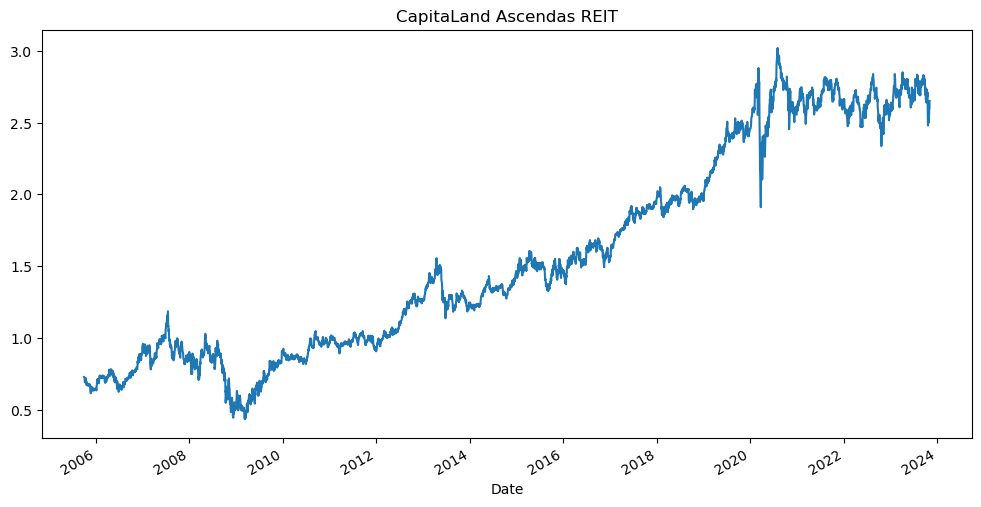

In [20]:
ticker = yf.Ticker('A17U.SI')
stock_df = ticker.history(period="max")
figure(figsize=(12, 6))
stock_df['Close'].plot(title="CapitaLand Ascendas REIT")

In [21]:
stock_df.head()

Open      High       Low     Close   Volume  \
Date                                                                         
2005-09-30 00:00:00+08:00  0.740827  0.740827  0.727478  0.730816  5001041   
2005-10-03 00:00:00+08:00  0.727478  0.730816  0.720806  0.724144  3696959   
2005-10-04 00:00:00+08:00  0.724144  0.724144  0.717468  0.720806  2252786   
2005-10-05 00:00:00+08:00  0.720806  0.720806  0.707457  0.707457  3284927   
2005-10-06 00:00:00+08:00  0.704119  0.707457  0.690771  0.694109  5603638   

                           Dividends  Stock Splits  
Date                                                
2005-09-30 00:00:00+08:00   0.029384           0.0  
2005-10-03 00:00:00+08:00   0.000000           0.0  
2005-10-04 00:00:00+08:00   0.000000           0.0  
2005-10-05 00:00:00+08:00   0.000000           0.0  
2005-10-06 00:00:00+08:00   0.000000           0.0

# 2. Computing trade signals

There are different types of moving averages, such as simple moving average, weighted moving average or exponential moving average. The
difference between the types is how the average is computed based on the weight assigned to data points. Simple moving average can be computed by simply taking the mean of the data points. The period to compute the moving average is a parameter. You can have a 200 days simple moving average, a 5 days simple moving average etc. Here' we compute a fast 20 days and slow 100 days moving average on the close price.

In [22]:
df=stock_df
# create 20 days simple moving average column
df['Fast_SMA'] = df['Close'].rolling(window = 20, min_periods = 1).mean()
# create 50 days simple moving average column
df['Slow_SMA'] = df['Close'].rolling(window = 100, min_periods = 1).mean()
# display first few rows
df.head()

Open      High       Low     Close   Volume  \
Date                                                                         
2005-09-30 00:00:00+08:00  0.740827  0.740827  0.727478  0.730816  5001041   
2005-10-03 00:00:00+08:00  0.727478  0.730816  0.720806  0.724144  3696959   
2005-10-04 00:00:00+08:00  0.724144  0.724144  0.717468  0.720806  2252786   
2005-10-05 00:00:00+08:00  0.720806  0.720806  0.707457  0.707457  3284927   
2005-10-06 00:00:00+08:00  0.704119  0.707457  0.690771  0.694109  5603638   

                           Dividends  Stock Splits  Fast_SMA  Slow_SMA  
Date                                                                    
2005-09-30 00:00:00+08:00   0.029384           0.0  0.730816  0.730816  
2005-10-03 00:00:00+08:00   0.000000           0.0  0.727480  0.727480  
2005-10-04 00:00:00+08:00   0.000000           0.0  0.725255  0.725255  
2005-10-05 00:00:00+08:00   0.000000           0.0  0.720806  0.720806  
2005-10-06 00:00:00+08:00   0.000000           0.0  0.715466  0.715466

There many moving average strategies that can be developed to generate trade signals. here we will use a simple moving average crossover strategy based on the SMAs we computed. A moving average can be use to indicate price trends. A crossover occurs when a faster or shorter moving average, such as the 20 days SMA crosses a slower or longer moving average, such as the 100 days SMA. This crossover  point can be used as a  indicator to buy or sell a stock.

First we create a new column ‘Signal’ such that if Fast_SMA is greater than Slow_SMA then set to 1 else set to 0.


In [23]:
df['Signal'] = 0.0
df['Signal'] = np.where(df['Fast_SMA'] > df['Slow_SMA'], 1.0, 0.0)

We now need to generate the buy and sell from the ‘Signal’ values. Crossover happens when the Fast_SMA and the Slow_SMA cross,  the ‘Signal’ changes from 0 to 1, or from 1 to 0. Thus we can just create a ‘Position’ value to indicate a day-to-day difference of the ‘Signal’ column.

‘Position’ = 1 implies that Signal changed from 0 to 1, meaning a faster moving average has crossed a slower moving average. This indicates a bull or up trend in the price and thus this is a buy signal.

‘Position’ = -1 implies that  Signal changed from 1 to 0, meaning a faster moving average has crossed below a slower moving average. This indicates a bear or down trend in the price and thus this is a sell signal.

In [24]:
df['Position'] = df['Signal'].diff()
# Need to set the first row of Position to 0. Otherwise it is nan from diff function.
df['Position'].iloc[0]=0
# display first few rows
df.head()


C:\Users\jeffl\AppData\Local\Temp\ipykernel_34236\2141737872.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Position'].iloc[0]=0


Open      High       Low     Close   Volume  \
Date                                                                         
2005-09-30 00:00:00+08:00  0.740827  0.740827  0.727478  0.730816  5001041   
2005-10-03 00:00:00+08:00  0.727478  0.730816  0.720806  0.724144  3696959   
2005-10-04 00:00:00+08:00  0.724144  0.724144  0.717468  0.720806  2252786   
2005-10-05 00:00:00+08:00  0.720806  0.720806  0.707457  0.707457  3284927   
2005-10-06 00:00:00+08:00  0.704119  0.707457  0.690771  0.694109  5603638   

                           Dividends  Stock Splits  Fast_SMA  Slow_SMA  \
Date                                                                     
2005-09-30 00:00:00+08:00   0.029384           0.0  0.730816  0.730816   
2005-10-03 00:00:00+08:00   0.000000           0.0  0.727480  0.727480   
2005-10-04 00:00:00+08:00   0.000000           0.0  0.725255  0.725255   
2005-10-05 00:00:00+08:00   0.000000           0.0  0.720806  0.720806   
2005-10-06 00:00:00+08:00   0.000000           0.0  0.715466  0.715466   

                           Signal  Position  
Date                                         
2005-09-30 00:00:00+08:00     0.0       0.0  
2005-10-03 00:00:00+08:00     0.0       0.0  
2005-10-04 00:00:00+08:00     0.0       0.0  
2005-10-05 00:00:00+08:00     0.0       0.0  
2005-10-06 00:00:00+08:00     0.0       0.0

<Axes: xlabel='Date'>

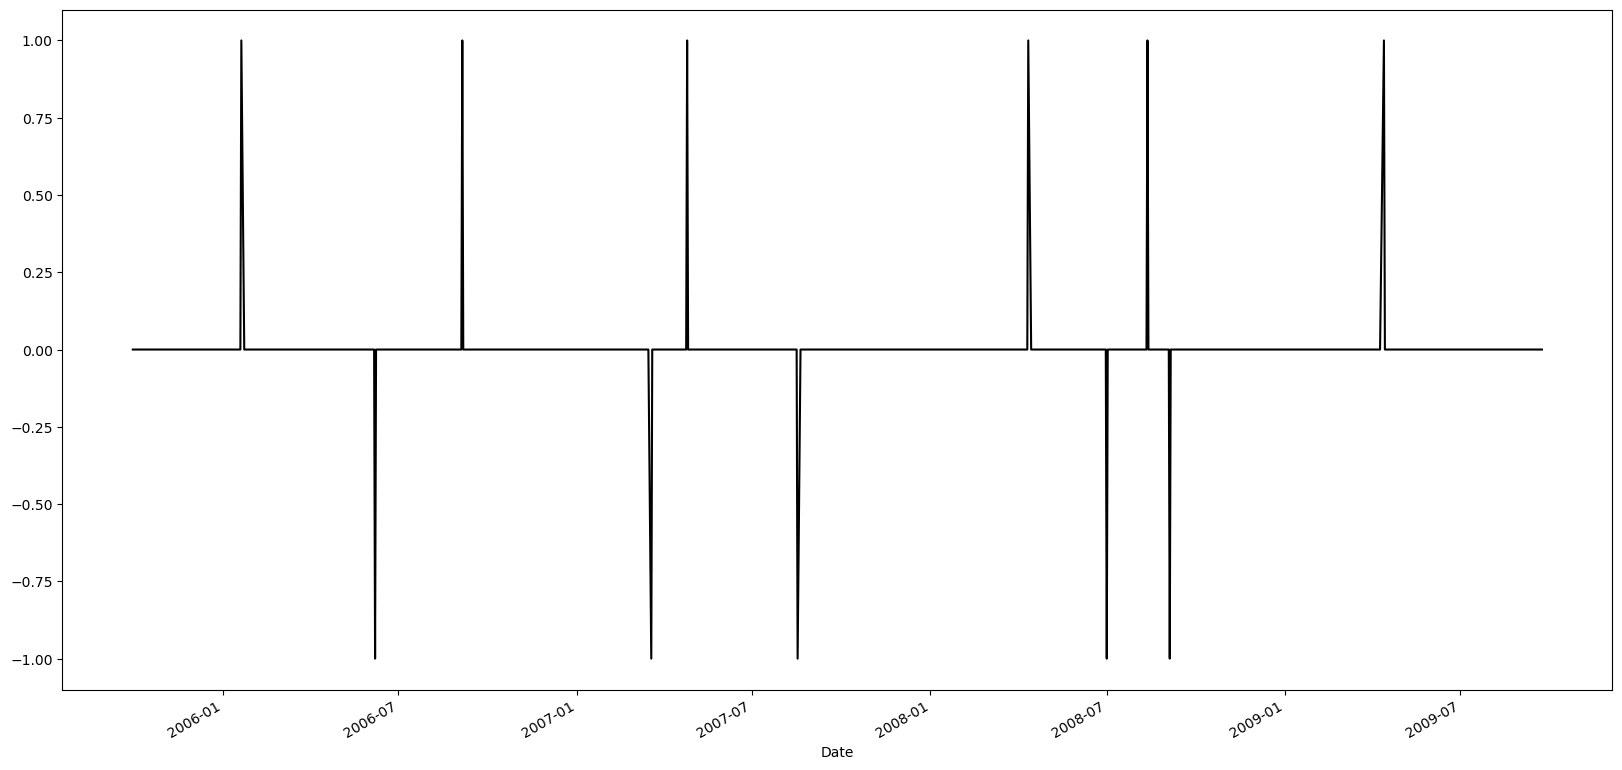

In [25]:
# Plot the positions
plt.figure(figsize = (20,10))
df.iloc[0:1000]['Position'].plot(color = 'k', label= 'Position')


Next we need to change the position signal to trade signals. Although position can give us this information, we want the change in the trade signal, which is the change from -1 to 1 to indicate a buy, and 1 to -1 to indicate a sell. This is for computing the Multiplicative Portfolio Returns.

0.0


<Axes: xlabel='Date'>

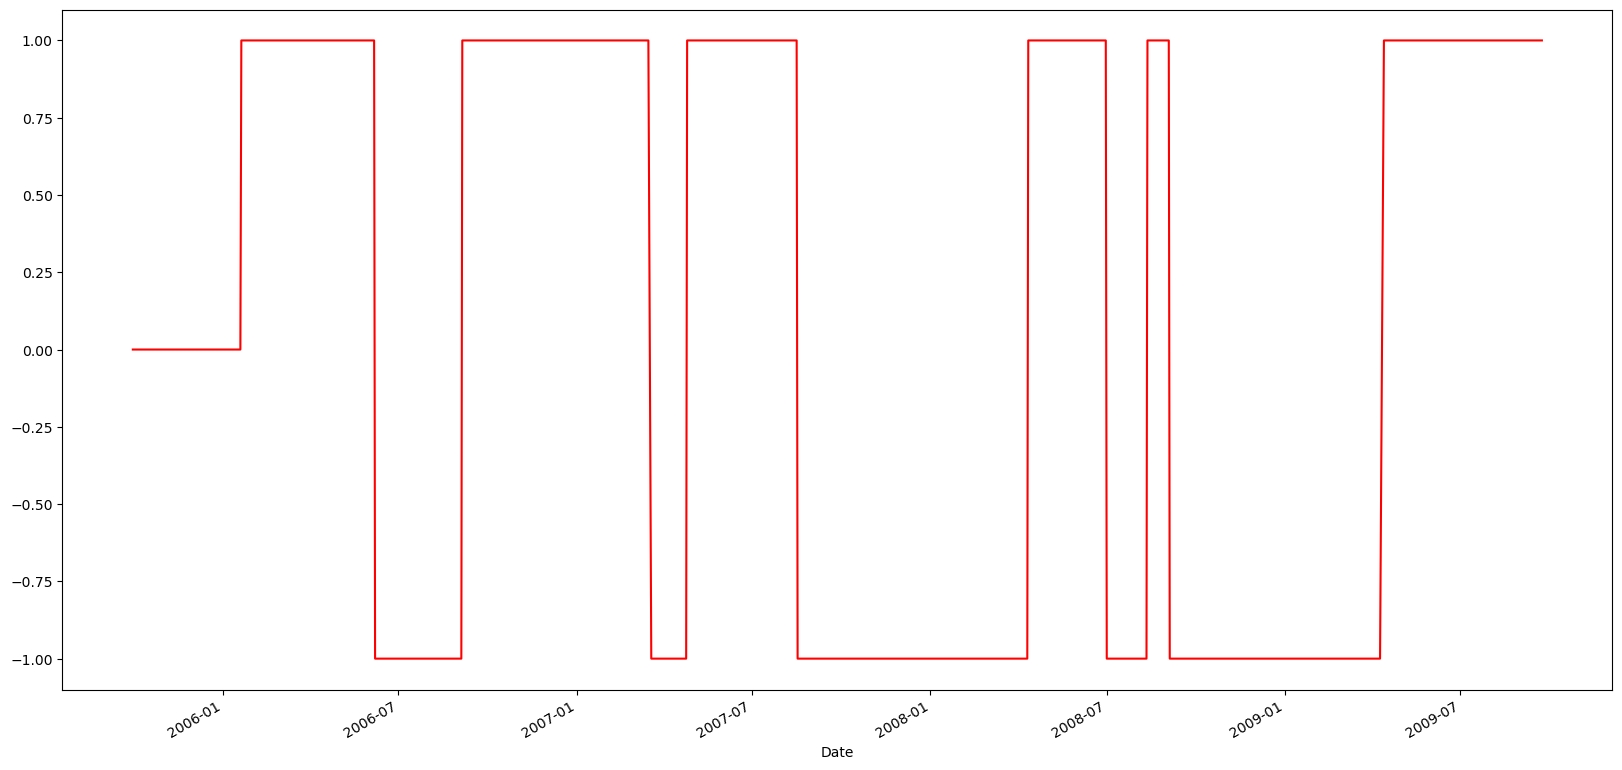

In [26]:
plt.figure(figsize = (20,10))
df['Trade'] = df['Position']
prevrow = df.iloc[0]
print(prevrow['Position'])
for index, row in df.iloc[1:].iterrows():
  if row['Trade']==0:
    if prevrow['Trade']!=0:
      df.at[index,'Trade']=prevrow['Trade']
      row['Trade']=prevrow['Trade']
  prevrow=row
df.iloc[0:1000]['Trade'].plot(color = 'r', label= 'Trade')

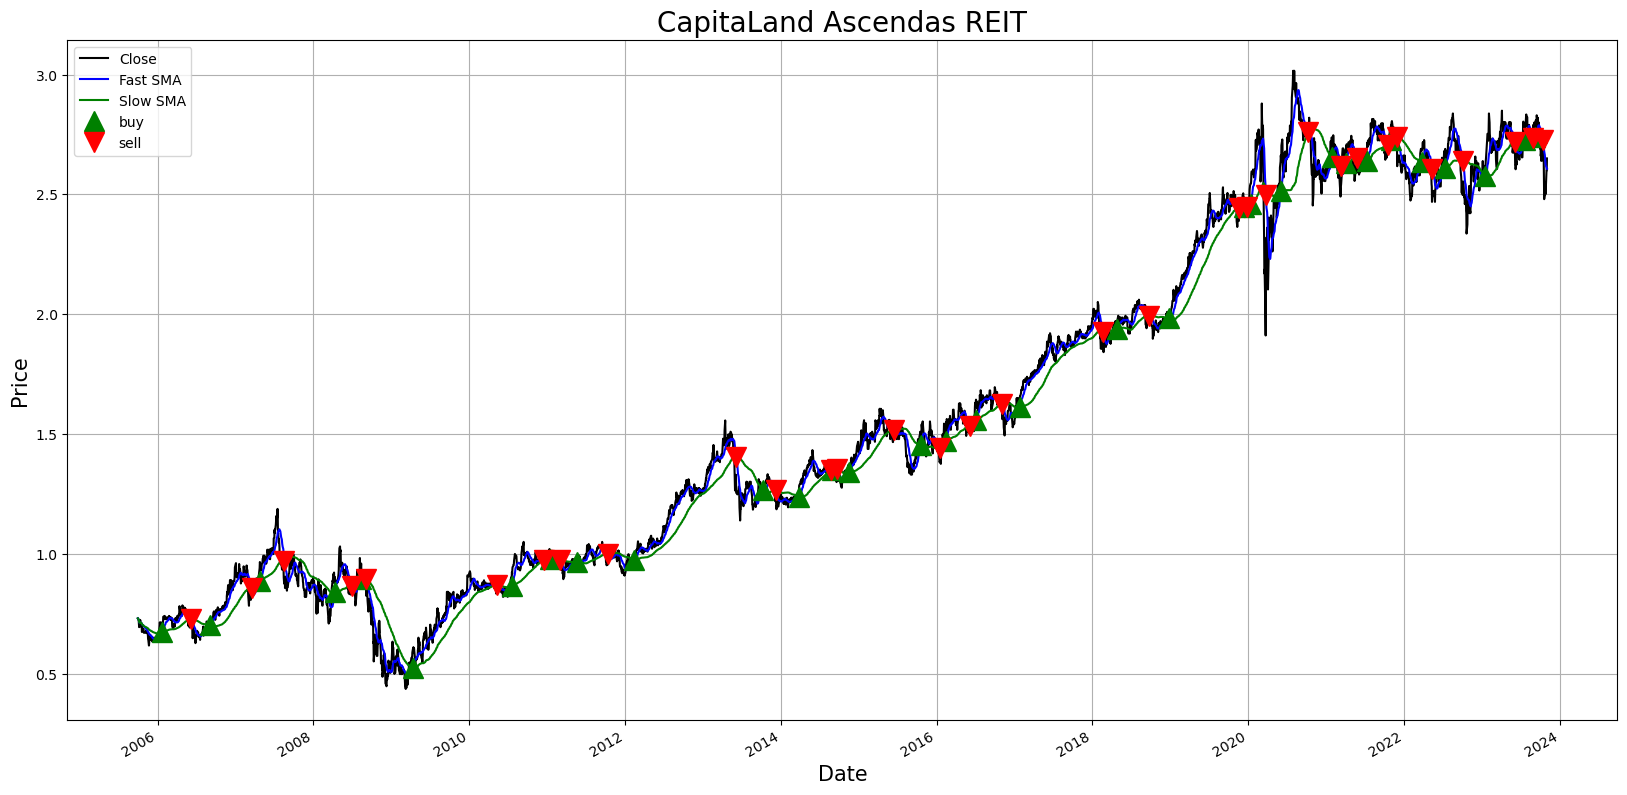

In [27]:
# plot close price, Fast and Slow simple moving averages
def plotprice(df):
  plt.figure(figsize = (20,10))
  df['Close'].plot(color = 'k', label= 'Close')
  df['Fast_SMA'].plot(color = 'b', label = 'Fast SMA')
  df['Slow_SMA'].plot(color = 'g', label = 'Slow SMA')
  # plot buy signals
  plt.plot(df[df['Position'] == 1].index, df['Fast_SMA'][df['Position'] == 1], '^', markersize = 15, color = 'g', label = 'buy')
  # plot sell signals
  plt.plot(df[df['Position'] == -1].index, df['Fast_SMA'][df['Position'] == -1], 'v', markersize = 15, color = 'r', label = 'sell')
  plt.ylabel('Price', fontsize = 15 )
  plt.xlabel('Date', fontsize = 15 )
  plt.title('CapitaLand Ascendas REIT', fontsize = 20)
  plt.legend()
  plt.grid()
  plt.show()

plotprice(df)

It is not very clear in the plot above since it included the prices of many years. Lets zoom in to take a closer look.

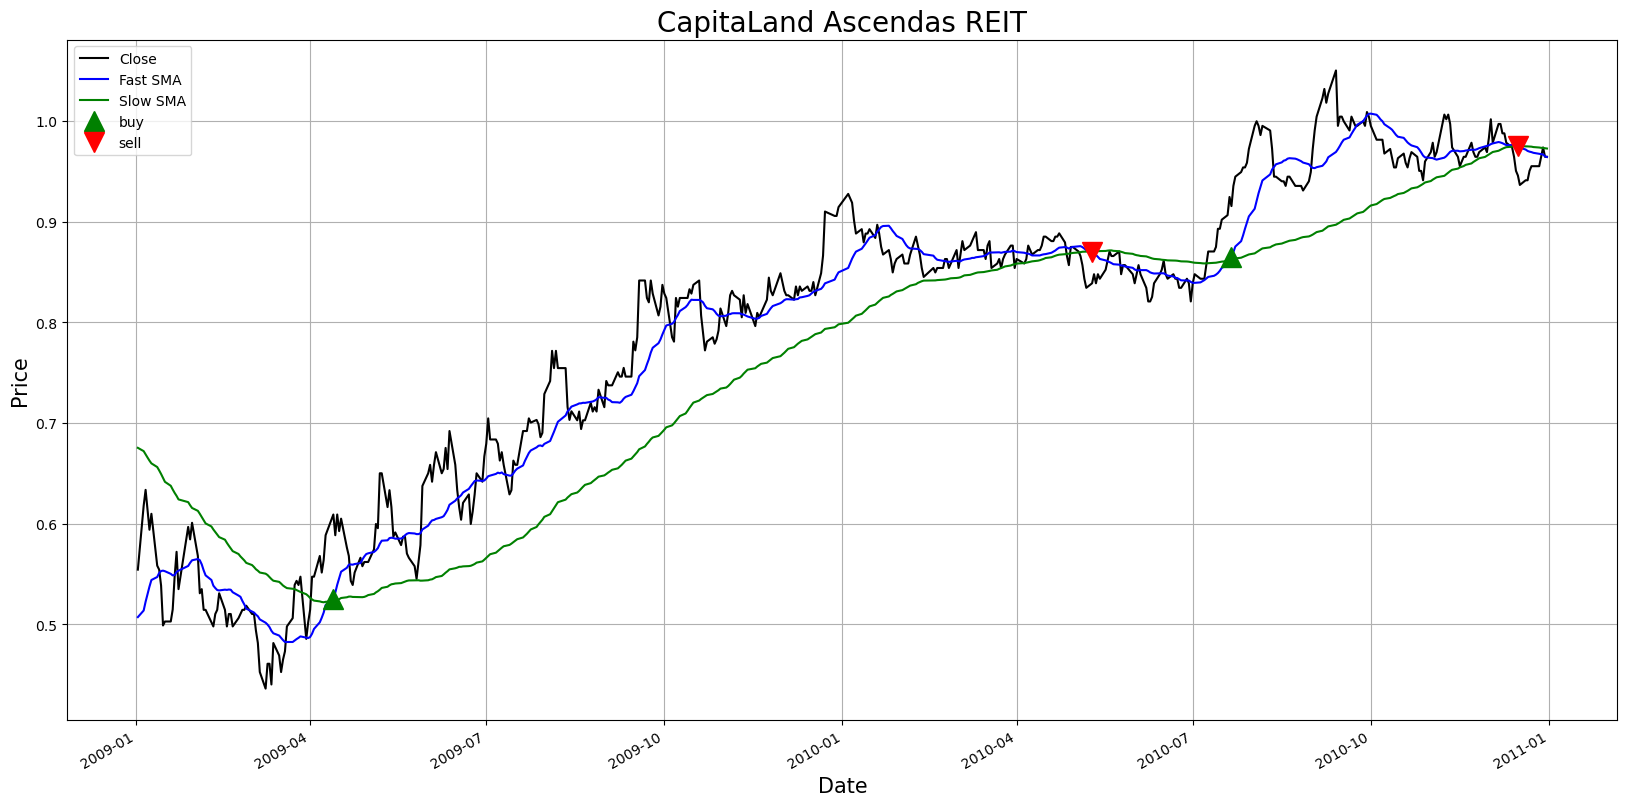

In [28]:
sdf=df.loc['2009-01-01':'2010-12-31']
plotprice(sdf)


Notice that there is a buy at Apr 2009, but the buy and sell are performed at almost the same price at around May 2010. Since each trade incurs a transaction cost, trades at around the same price will result in losses. Hence a better trading strategy can be implemented, such as the introduction of a moving average band to reduce the number of trades around the same price. Refer to the paper on this for more details.

# 3. Computing portfolio returns

The computation of portfolio returns in this section is based on the multiplicative returns given by (refer equation 11 of the reference paper)

$\begin{equation}
R(T)=\{1+F(T-1)r(T)\}\{1-\delta|F(T)-F(T-1)|\}
\end{equation}$

where $r(T)=(y(T)/y(T-1))-1$; $y(T)$ is the closing price at time $T$; $F(T)$ is the action from the trading system; and $\delta$ is the transaction rate.

The multplicative profits $R$ can computed using

$\begin{equation}
R=\prod\limits_{T = 1}^{n} R(T)
\end{equation}$

where $n$ is the total number of time points.


0.0


<Axes: xlabel='Date'>

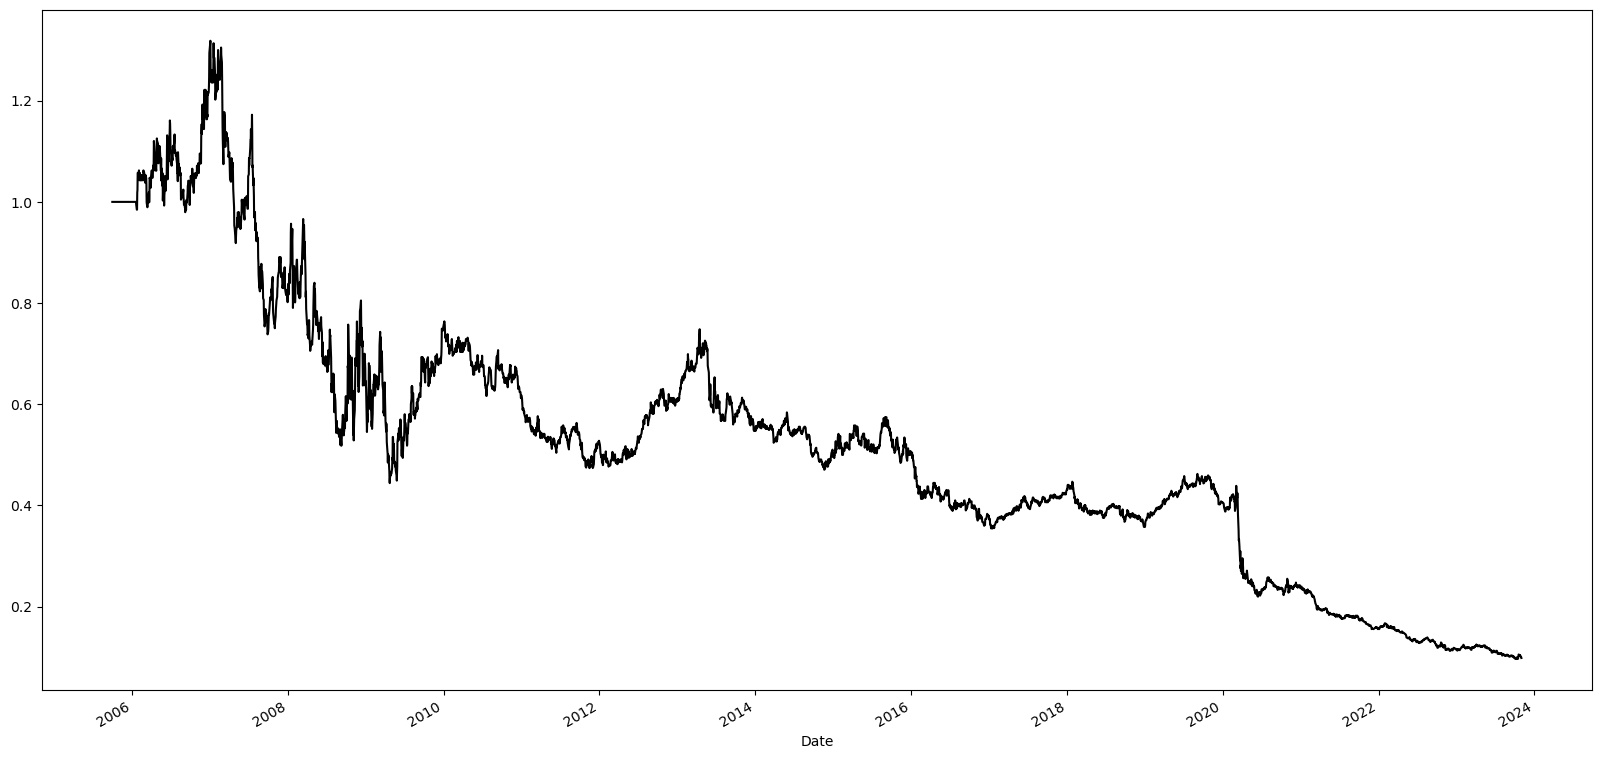

In [29]:
df['Returns']=1.0
print(df.iloc[1]['Trade'])

def computereturns(tdf,trate):
  prevrow = tdf.iloc[0]
  returncol=tdf.columns.get_loc('Returns')
  for i in range(len(tdf)):
    if i==0:
      prev_i=i
    else:
      prevrow=tdf.iloc[prev_i]
      row=tdf.iloc[i]
      rt=(row['Close']/prevrow['Close'])-1
      t=prevrow['Returns']*(1+prevrow['Trade']*rt)*(1-trate*abs(row['Trade']-prevrow['Trade']))
      tdf.iat[i,returncol]=t
      prev_i=i
  return tdf

df=computereturns(df,0.005)
plt.figure(figsize = (20,10))
#df.iloc[1:1000]['Returns'].plot(color = 'k', label= 'Returns')
df['Returns'].plot(color = 'k', label= 'Returns')


Notice in the above plot that some times the portfolio returns dropped below 1.0, some times it rises above 2.0. Hence this shows that the choice of trading strategy and parameters are very important to yield either profits or losses. Above 1.0 indicates there is overall profit. Less than 1.0 indicates there is a loss.


## Data preprocessing

In [30]:
close = df["Close"]
close = pd.DataFrame(close)
close.head()

Close
Date                               
2005-09-30 00:00:00+08:00  0.730816
2005-10-03 00:00:00+08:00  0.724144
2005-10-04 00:00:00+08:00  0.720806
2005-10-05 00:00:00+08:00  0.707457
2005-10-06 00:00:00+08:00  0.694109

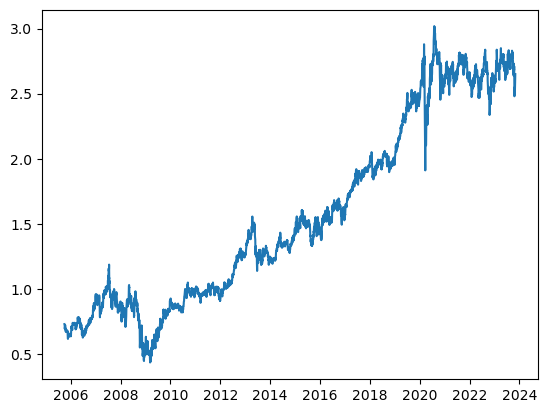

In [31]:
plt.plot(close.index, close)

In [32]:
def prepare_dataset(dataframe, col_name, frame_size=20):
  dataframe = dc(dataframe)
  for i in range(1, frame_size):
    dataframe[f'{col_name}(t-{i})'] = dataframe[f'{col_name}'].shift(i)
  dataframe.dropna(inplace=True)
  return dataframe

def subtraction(dataframe):
  dataframe = prepare_dataset(dataframe, 'Close', frame_size=2)
  dataframe['difference'] = dataframe['Close'] - dataframe['Close(t-1)']
  dataframe.dropna(inplace=True)
  return dataframe

# change window to Change the time shift window size
window = 20
close = subtraction(close)
close = pd.DataFrame(close['difference'])
close_frame = prepare_dataset(close, 'difference', frame_size=20)
close_frame.head()

difference  difference(t-1)  difference(t-2)  \
Date                                                                      
2005-10-28 00:00:00+08:00   -0.010010          0.00000        -0.006673   
2005-10-31 00:00:00+08:00    0.000000         -0.01001         0.000000   
2005-11-02 00:00:00+08:00    0.000000          0.00000        -0.010010   
2005-11-04 00:00:00+08:00    0.000000          0.00000         0.000000   
2005-11-07 00:00:00+08:00    0.006672          0.00000         0.000000   

                           difference(t-3)  difference(t-4)  difference(t-5)  \
Date                                                                           
2005-10-28 00:00:00+08:00         0.006673        -0.006673         0.010010   
2005-10-31 00:00:00+08:00        -0.006673         0.006673        -0.006673   
2005-11-02 00:00:00+08:00         0.000000        -0.006673         0.006673   
2005-11-04 00:00:00+08:00        -0.010010         0.000000        -0.006673   
2005-11-07 00:00:00+08:00         0.000000        -0.010010         0.000000   

                           difference(t-6)  difference(t-7)  difference(t-8)  \
Date                                                                           
2005-10-28 00:00:00+08:00         0.003338        -0.023362         0.003338   
2005-10-31 00:00:00+08:00         0.010010         0.003338        -0.023362   
2005-11-02 00:00:00+08:00        -0.006673         0.010010         0.003338   
2005-11-04 00:00:00+08:00         0.006673        -0.006673         0.010010   
2005-11-07 00:00:00+08:00        -0.006673         0.006673        -0.006673   

                           difference(t-9)  difference(t-10)  \
Date                                                           
2005-10-28 00:00:00+08:00        -0.013348          0.000000   
2005-10-31 00:00:00+08:00         0.003338         -0.013348   
2005-11-02 00:00:00+08:00        -0.023362          0.003338   
2005-11-04 00:00:00+08:00         0.003338         -0.023362   
2005-11-07 00:00:00+08:00         0.010010          0.003338   

                           difference(t-11)  difference(t-12)  \
Date                                                            
2005-10-28 00:00:00+08:00         -0.006672         -0.010014   
2005-10-31 00:00:00+08:00          0.000000         -0.006672   
2005-11-02 00:00:00+08:00         -0.013348          0.000000   
2005-11-04 00:00:00+08:00          0.003338         -0.013348   
2005-11-07 00:00:00+08:00         -0.023362          0.003338   

                           difference(t-13)  difference(t-14)  \
Date                                                            
2005-10-28 00:00:00+08:00          0.016687          0.003338   
2005-10-31 00:00:00+08:00         -0.010014          0.016687   
2005-11-02 00:00:00+08:00         -0.006672         -0.010014   
2005-11-04 00:00:00+08:00          0.000000         -0.006672   
2005-11-07 00:00:00+08:00         -0.013348          0.000000   

                           difference(t-15)  difference(t-16)  \
Date                                                            
2005-10-28 00:00:00+08:00          0.010010         -0.013348   
2005-10-31 00:00:00+08:00          0.003338          0.010010   
2005-11-02 00:00:00+08:00          0.016687          0.003338   
2005-11-04 00:00:00+08:00         -0.010014          0.016687   
2005-11-07 00:00:00+08:00         -0.006672         -0.010014   

                           difference(t-17)  difference(t-18)  \
Date                                                            
2005-10-28 00:00:00+08:00         -0.013348         -0.003338   
2005-10-31 00:00:00+08:00         -0.013348         -0.013348   
2005-11-02 00:00:00+08:00          0.010010         -0.013348   
2005-11-04 00:00:00+08:00          0.003338          0.010010   
2005-11-07 00:00:00+08:00          0.016687          0.003338   

                           difference(t-19)  
Date                                         
2005-10-28 00:

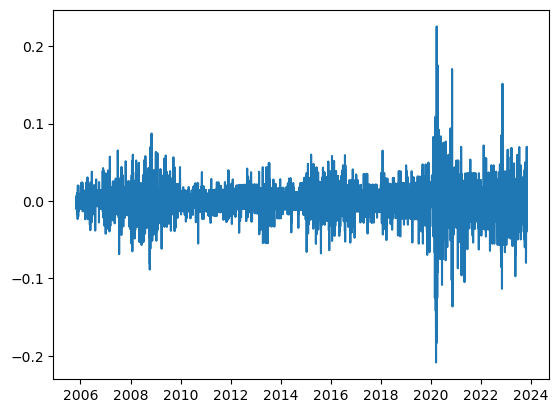

In [34]:
plt.plot(close_frame.index, close_frame['difference'])

In [35]:
close_frame_np = close_frame.to_numpy()
close_frame_np[:5]

array([[-0.01000994,  0.        , -0.00667274,  0.00667274, -0.00667274,
         0.0100103 ,  0.0033381 , -0.02336246,  0.00333804, -0.0133484 ,
         0.        , -0.00667226, -0.01001436,  0.01668662,  0.00333798,
         0.01001042, -0.0133484 , -0.01334846, -0.00333816, -0.00667238],
       [ 0.        , -0.01000994,  0.        , -0.00667274,  0.00667274,
        -0.00667274,  0.0100103 ,  0.0033381 , -0.02336246,  0.00333804,
        -0.0133484 ,  0.        , -0.00667226, -0.01001436,  0.01668662,
         0.00333798,  0.01001042, -0.0133484 , -0.01334846, -0.00333816],
       [ 0.        ,  0.        , -0.01000994,  0.        , -0.00667274,
         0.00667274, -0.00667274,  0.0100103 ,  0.0033381 , -0.02336246,
         0.00333804, -0.0133484 ,  0.        , -0.00667226, -0.01001436,
         0.01668662,  0.00333798,  0.01001042, -0.0133484 , -0.01334846],
       [ 0.        ,  0.        ,  0.        , -0.01000994,  0.        ,
        -0.00667274,  0.00667274, -0.00667274,  

In [36]:
X = close_frame_np[:, 1:]
y = close_frame_np[:, 0]
X.shape, y.shape

((4521, 19), (4521,))

In [41]:
split_pt = int(np.ceil(X.shape[0]*0.75))
split_pt

3391

In [42]:
X_train = torch.tensor(X[:split_pt]).float()
X_test = torch.tensor(X[split_pt:]).float()
y_train = torch.tensor(y[:split_pt]).float()
y_test = torch.tensor(y[split_pt:]).float()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3391, 19]),
 torch.Size([1130, 19]),
 torch.Size([3391]),
 torch.Size([1130]))

In [47]:
batch_size = 128
training_loader = load_window_frame_dataset(X_train, y_train, batch_size)
testing_loader = load_window_frame_dataset(X_test, y_test, batch_size)